<a href="https://colab.research.google.com/github/Int-Group-44/flowers-102/blob/main/OxfordFlowers102CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing TensorFlow 

In [3]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 1020
num_validation_examples = 1020

In [4]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    #label = tf.one_hot(label, depth=num_classes)
    return image, label
BATCH_SIZE = 16
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [5]:
def make_model(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.RandomFlip("horizontal", input_shape=input_shape))
  model.add(layers.RandomRotation(20))
  model.add(layers.RandomZoom(0.1))
  model.add(layers.RandomContrast(0.25))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.35))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.35))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.35))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(num_classes))
  return model


In [6]:
tf.keras.backend.clear_session()
model = make_model(input_shape=(IMAGE_RES, IMAGE_RES) + (3,), num_classes=102)

In [7]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 200

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

64/64 [==============================] - 10s 152ms/step - loss: 2.7259 - accuracy: 0.3343 - val_loss: 3.5158 - val_accuracy: 0.2990
Epoch 104/200
64/64 [==============================] - 10s 152ms/step - loss: 2.7505 - accuracy: 0.3147 - val_loss: 3.5464 - val_accuracy: 0.2922
Epoch 105/200
64/64 [==============================] - 12s 190ms/step - loss: 2.6971 - accuracy: 0.3353 - val_loss: 3.4942 - val_accuracy: 0.3029
Epoch 106/200
64/64 [==============================] - 10s 158ms/step - loss: 2.7482 - accuracy: 0.3304 - val_loss: 3.9342 - val_accuracy: 0.2892
Epoch 107/200
64/64 [==============================] - 10s 143ms/step - loss: 2.7184 - accuracy: 0.3461 - val_loss: 3.4161 - val_accuracy: 0.3108
Epoch 108/200
64/64 [==============================] - 10s 152ms/step - loss: 2.6656 - accuracy: 0.3598 - val_loss: 3.3765 - val_accuracy: 0.3078
Epoch 109/200
64/64 [==============================] - 10s 146ms/step - loss: 2.6913 - accuracy: 0.3304 - val_loss: 3.4661 - val_accuracy:

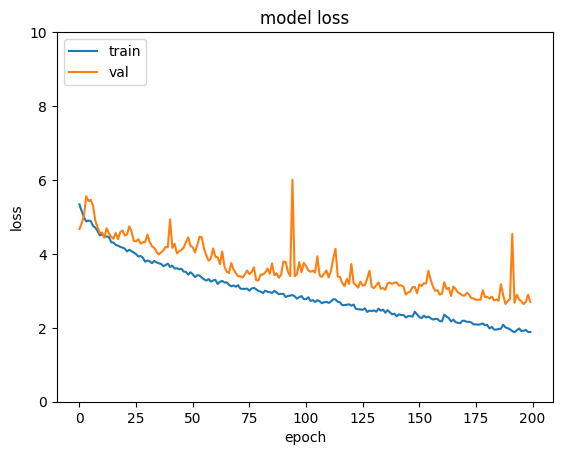

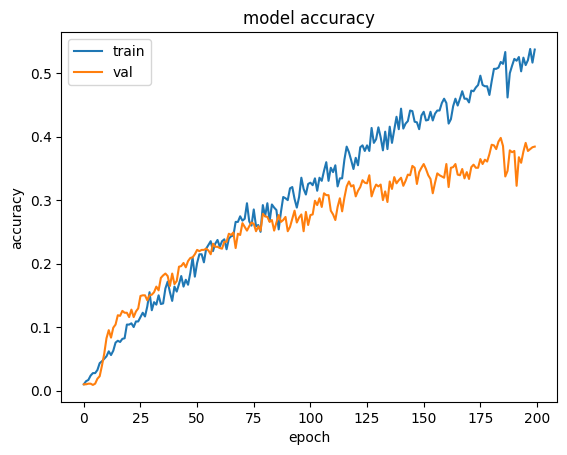

In [8]:
tloss1 = history.history['loss']
vloss1 = history.history['val_loss']
tacc1 = history.history['accuracy']
vacc1 = history.history['val_accuracy']

plt.plot(tloss1)
plt.ylim(0,10)
plt.plot(vloss1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

plt.plot(tacc1)
plt.plot(vacc1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

In [9]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 200

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/200
64/64 [==============================] - 24s 189ms/step - loss: 1.8534 - accuracy: 0.5255 - val_loss: 2.6667 - val_accuracy: 0.3990
Epoch 2/200
64/64 [==============================] - 10s 146ms/step - loss: 1.8255 - accuracy: 0.5490 - val_loss: 2.6033 - val_accuracy: 0.4010
Epoch 3/200
64/64 [==============================] - 9s 134ms/step - loss: 1.7960 - accuracy: 0.5549 - val_loss: 2.6058 - val_accuracy: 0.4059
Epoch 4/200
64/64 [==============================] - 9s 134ms/step - loss: 1.8012 - accuracy: 0.5441 - val_loss: 2.6727 - val_accuracy: 0.3941
Epoch 5/200
64/64 [==============================] - 9s 138ms/step - loss: 1.7678 - accuracy: 0.5588 - val_loss: 2.8149 - val_accuracy: 0.3863
Epoch 6/200
64/64 [==============================] - 10s 146ms/step - loss: 1.8081 - accuracy: 0.5539 - val_loss: 2.9147 - val_accuracy: 0.4049
Epoch 7/200
64/64 [==============================] - 12s 184ms/step - loss: 1.7362 - accuracy: 0.5676 - val_loss: 2.6366 - val_accuracy: 0.

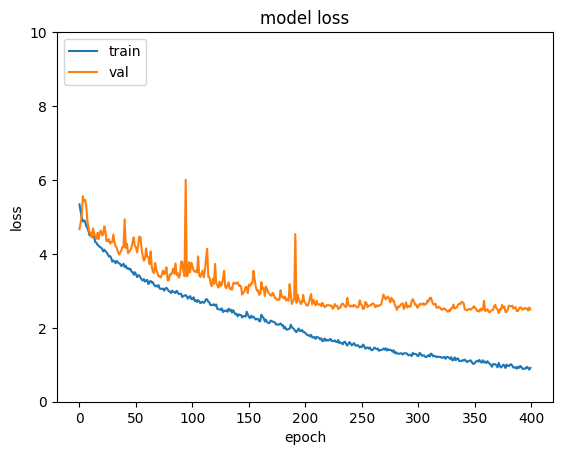

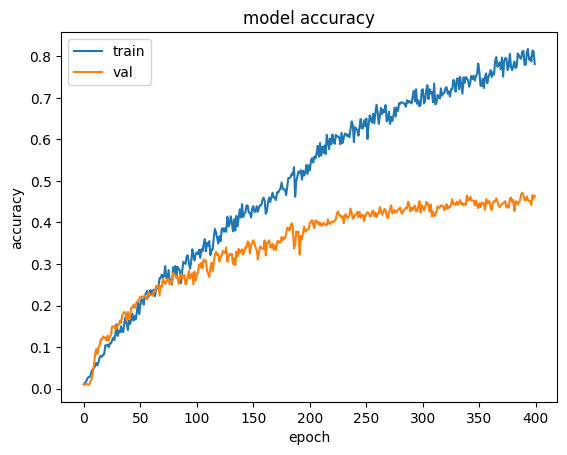

In [10]:
tloss2 = history.history['loss']
vloss2 = history.history['val_loss']
tacc2 = history.history['accuracy']
vacc2 = history.history['val_accuracy']

plt.plot(tloss1+tloss2)
plt.ylim(0,10)
plt.plot(vloss1+vloss2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

plt.plot(tacc1+tacc2)
plt.plot(vacc1+vacc2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

In [11]:
#keras.utils.plot_model(model, show_shapes=True)

epochs = 100

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/100
64/64 [==============================] - 21s 156ms/step - loss: 0.9294 - accuracy: 0.7873 - val_loss: 2.5031 - val_accuracy: 0.4627
Epoch 2/100
64/64 [==============================] - 9s 140ms/step - loss: 0.9041 - accuracy: 0.8039 - val_loss: 2.4883 - val_accuracy: 0.4637
Epoch 3/100
64/64 [==============================] - 12s 188ms/step - loss: 0.9046 - accuracy: 0.7892 - val_loss: 2.4783 - val_accuracy: 0.4696
Epoch 4/100
64/64 [==============================] - 10s 153ms/step - loss: 0.8774 - accuracy: 0.8108 - val_loss: 2.4686 - val_accuracy: 0.4686
Epoch 5/100
64/64 [==============================] - 9s 141ms/step - loss: 0.8884 - accuracy: 0.7912 - val_loss: 2.4611 - val_accuracy: 0.4647
Epoch 6/100
64/64 [==============================] - 10s 142ms/step - loss: 0.8791 - accuracy: 0.8059 - val_loss: 2.4783 - val_accuracy: 0.4657
Epoch 7/100
64/64 [==============================] - 10s 147ms/step - loss: 0.9011 - accuracy: 0.7941 - val_loss: 2.4811 - val_accuracy: 0

In [12]:
tloss3 = history.history['loss']
vloss3 = history.history['val_loss']
tacc3 = history.history['accuracy']
vacc3 = history.history['val_accuracy']

In [53]:
model.save('OxfordFlowers102-2.keras')

In [13]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1, batch_size=BATCH_SIZE)
print("Test accuracy:", test_acc)

385/385 [==============================] - 14s 35ms/step - loss: 2.7245 - accuracy: 0.4022
Test accuracy: 0.40217921137809753


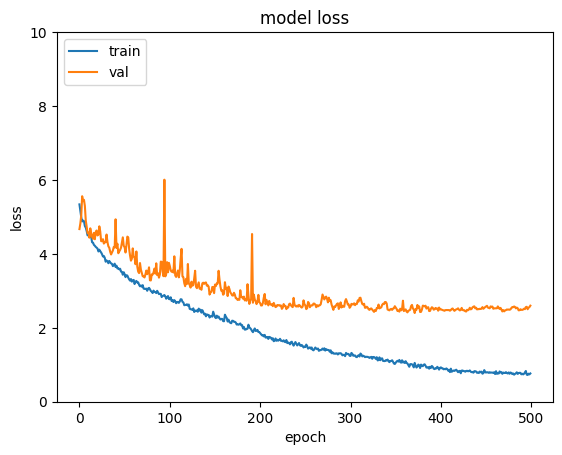

In [14]:
plt.plot(tloss1+tloss2+tloss3)
plt.ylim(0,10)
plt.plot(vloss1+vloss2+vloss3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

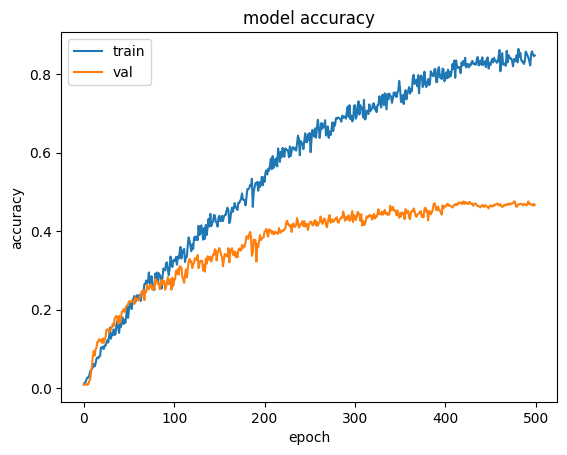

In [15]:
plt.plot(tacc1+tacc2+tacc3)
plt.plot(vacc1+vacc2+vacc3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()